<a href="https://colab.research.google.com/github/andreibuiciuc/logistic_regression_classifier_numpy/blob/main/logistic_regression_classifier_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Logistic Regression Classifier -- Numpy Implementation**

> **Summary**: 
In this notebook, one builts a simple **Logistic Regression Model** for a binary classification problem. The implementation is done from scratch with the help of the *numpy* Python package, the use of machine learning libraries/frameworks will be covered in future notebooks. 

> **Important to mention**: These notebooks come as additional practice problems
following the Deep Learning Specialization provided by deeplearning.ai on Coursera. 

> **Author**: Andrei Buiciuc, UBB Cluj-Napoca

### **Overview**


*   **Problem statement:** Given a dataset of bird/butterfly images, one wants to correctly classify pictures as *bird* (labeled as y = 0) or *non-bird* (y = 1) using Logistic Regression.
*   **Approach:** Before starting the model implementation, data preprocessing must be done, that means preparing and modifying raw data so it can be fed into the Linear Regression Model.
---
*   **Note**: Because of the use of Google Colab, the dataset can be stored in Drive, therefore Google Drive has to be mounted on the runtime.



In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

print("Setup complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete.


### **Data preprocessing**
Dataset used for this problem: [bird vs butterfly](https://www.kaggle.com/razinw/bird-vs-butterfly)

The dataset comes as a directory containing *train* and *test* subdirectories with the corresponding data. Prior to this, images have been renamed for labeling simplicity and also training and testing data has been devided by a 70% train - 30% test split ratio.

**Steps:**
1.   Extract the images from the corresponding training and testing directories.
2.   Open the images and then convert them to numpy arrays.
3.   Create training and testing numpy arrays for features and labels.
4.   Check and prepare vector dimensions.


The paths refer to the content from the Drive already mounted.

In [2]:
# Paths to the training directories
train_bird_dir_path = r'/content/drive/MyDrive/colab/datasets/birdvsbutterfly/train/0'
train_bfly_dir_path = r'/content/drive/MyDrive/colab/datasets/birdvsbutterfly/train/1'

# Paths to the testing directories
test_bird_dir_path = r'/content/drive/MyDrive/colab/datasets/birdvsbutterfly/test/0'
test_bfly_dir_path = r'/content/drive/MyDrive/colab/datasets/birdvsbutterfly/test/1'

The function *scandir* from the *os* module is used to iterate through the files in the training and testing directories, getting DirEntry objects holding, in particular, the filename string.

In [3]:
def get_image_entries(bird_dir_path, bfly_dir_path):
  """
  Helper function to get image-entries(as DirEntry objects) from given directories.
  
  Arguments:
  bird_dir_path : the path to the bird (train or test) subdirectory (for label 0)
  bfly_dir_path : the path to the bfly (train or test) subdirectory (for label 1)
  
  Returns:
  entries : list of DirEntry objects from both categories of images
  """

  entries = []
  for entry in os.scandir(bird_dir_path):
    entries.append(entry)
  for entry in os.scandir(bfly_dir_path):
    entries.append(entry)
  
  return entries

It is known that all the images in the dataset are of size (1000px, 1000px), so when the resize operation below is performed, the aspect ratio will remain the same. Also, images have 3 channels (RGB).


In [4]:
def get_data(entries, X, Y, bird_dir_path, bfly_dir_path):
  """
  Helper function to transform image objects into numpy image arrays.

  Arguments:
  entries : list of DirEntry objects
  X : input data matrix (train or test)
  Y : label matrix (train or test)
  bird_dir_path : the path to the bird (train or test) subdirectory
  bfly_dir_path : the path to the bfly (train or test) subdirectory
  """
  
  for entry in entries:
    label = 0 if "bird" in entry.name else 1
    if label == 0:
      image_path = bird_dir_path + '/' + entry.name
    else:
      image_path = bfly_dir_path + '/' + entry.name

    image = Image.open(image_path).convert("RGB")
    image = image.resize((100,100))
    image_array = np.array(image)
    X.append(image_array)
    Y.append(label)

**Preparing the training and testing data:**


*   Fetch image entries as DirEntry objects.
*   Shuffle the entries from both training and testing lists.
*   Create train and test numpy arrays together with the corresponding labels.

---
**Notes:**

The prefix *_orig* refers to the original state of the input data vectors, before applying other processing methods.

The process of opening and converting images might take a while.


In [5]:
# Training data
train_image_entries = get_image_entries(train_bird_dir_path, train_bfly_dir_path)
print("Number of train entries: ", len(train_image_entries))

random.shuffle(train_image_entries)
x_train_orig = []
y_train = []

get_data(train_image_entries, x_train_orig, y_train, train_bird_dir_path, train_bfly_dir_path)
print("Train data fetched.")

Number of train entries:  385
Train data fetched.


In [6]:
# Testing data
test_image_entries = get_image_entries(test_bird_dir_path, test_bfly_dir_path)
print("Number of test entries: ", len(test_image_entries))

x_test_orig = []
y_test = []

get_data(test_image_entries, x_test_orig, y_test, test_bird_dir_path, test_bfly_dir_path)
print("Test data fetched.")

Number of test entries:  165
Test data fetched.


In [7]:
# Transform into numpy array the train and test lists.
x_train_orig = np.array(x_train_orig)
y_train = np.array(y_train)
x_test_orig = np.array(x_test_orig)
y_test = np.array(y_test)

Explore the dataset and check some labels. Ploting is done using the *matplotlib* library for Python.

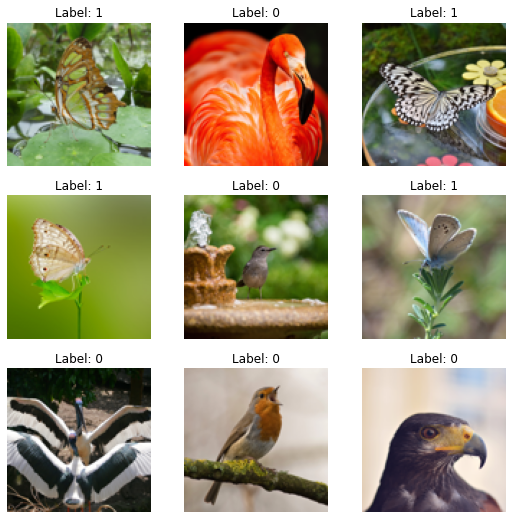

In [8]:
# Explore the dataset
fig = plt.figure(figsize=(9,9))
rows = 3
columns = 3
index = 0
axes = []

for i in range(1, rows * columns + 1):
  image = x_train_orig[index]
  axes.append(fig.add_subplot(rows, columns, i))
  axes[index].set_title("Label: " + str(np.squeeze(y_train[index])))
  axes[index].axis("off")
  plt.imshow(image)
  index += 1

plt.show()

* Check the dimensions before moving on to the model implementation.
* Flatten the image numpy arrays ( convert into arrays of shape n_px * p_px * 3). Then, the dataset is in fact numpy arrays (training and testing) where each column represents an image.
* Standardize the dataset: pixel values between 0 and 255 are translated into values between 0 and 1.

In [9]:
# Check the dimensions
m_train = x_train_orig.shape[0]
m_test = x_test_orig.shape[0]
m = m_train + m_test

train_percentage = m_train * 100 / m
test_percentage = m_test * 100 / m
n_px = x_train_orig.shape[1]

print("Number of total examples: ", m)
print("Number of training examples: ", m_train, " ,percentage: ", train_percentage, "%")
print("Number of testing examples: ", m_test,  " ,percentage: ", test_percentage, "%")
print("Each image is of shape: ", x_train_orig[0].shape)
print("Number of pixels: ", n_px)

print("\nx_train_orig shape: ", x_train_orig.shape)
print("y_train shape: ", y_train.shape)
print("x_test_orig shape: ", x_test_orig.shape)
print("y_test shape: ", y_test.shape)

# Flatten the input data
x_train_flatten = x_train_orig.reshape(x_train_orig.shape[0], -1).T
x_test_flatten = x_test_orig.reshape(x_test_orig.shape[0], -1).T

y_train = y_train.reshape((1, m_train))
y_test = y_test.reshape((1, m_test))

print("\nx_train_flatten shape: ", x_train_flatten.shape)
print("y_train shape after reshape: ", y_train.shape)
print("x_test_flatten shape: ", x_test_flatten.shape)
print("y_test shape after reshape: ", y_test.shape)

# Standardize
x_train = x_train_flatten / 255.
x_test = x_test_flatten / 255.

Number of total examples:  550
Number of training examples:  385  ,percentage:  70.0 %
Number of testing examples:  165  ,percentage:  30.0 %
Each image is of shape:  (100, 100, 3)
Number of pixels:  100

x_train_orig shape:  (385, 100, 100, 3)
y_train shape:  (385,)
x_test_orig shape:  (165, 100, 100, 3)
y_test shape:  (165,)

x_train_flatten shape:  (30000, 385)
y_train shape after reshape:  (1, 385)
x_test_flatten shape:  (30000, 165)
y_test shape after reshape:  (1, 165)


###**Logistic Regression Model**###

After each image has been converted into a feature vector together with its corresponding label, one can build a neural network inspired model for Logistic Regression, that is a neural network with only one neuron.

**Steps:**
* Forward propagation
    * Compute z: the value before activation 
    * Compute a: the value after activation
    * **Compute the cost:** cross entropy cost
* Backward propagation
    * **Compute the gradients**: dw, db.
* Gradient descent
    * **Update the parameters** using the update rule.



The neuron has as activation function the sigmoid.

In [10]:
def sigmoid(z):
  """
  Helper function to compute the sigmoid.

  Argument:
  z : numpy array

  Returns:
  a numpy array with values through the sigmoid function
  """
  return (1 / (1 + np.exp(-z)))

In general, the parameters of Logistic Regression are initialized with zeros.

In [11]:
def init_parameters(dimension):
  """
  Initializes the parameters of the model.

  Arguments:
  dimension: size of the weight vector = n_px * n_px * 3

  Returns:
  w : weight vector of shape: (dimension, 1)
  b : bias, real number, initially zero  
  """

  w = np.zeros((dimension, 1))
  b = 0

  assert(w.shape == (dimension, 1))
  return w, b


*Forward propagation(mathematical algorithm):*

![](https://drive.google.com/uc?export=view&id=1yrJB3QhGwxaj488sjzP4I06bsUoO3M_D)

---
**Note:** The forward propagation calculus image has been made using a LaTeX to image converter.


In [12]:
def forward(w, b, X, Y):
  """
  Forward propagation of Logistic Regression.

  Arguments:
  w : weight vector of shape: (n_x * n_x * 3, 1)
  b : bias, real number
  X : input data of shape: (n_x * n_x * 3, number_of_examples)
  Y : labels vector of shape: (1, number_of_examples)

  Returns:
  A : the value after the activation function
  cost: cross-entropy cost
  """
  m = X.shape[1]
  A = sigmoid(np.dot(w.T, X) + b)
  cost = (-1/m) * (np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)))

  # use np.squeeze to get rid of redundant vector brackets
  cost = np.squeeze(cost)

  assert(cost.shape == ())

  return A, cost

*Backward propagation(mathematical algorithm):*

![](https://drive.google.com/uc?export=view&id=1jODtSTvJy1HftqVJ_JBvlUoes4XRlUW3)

---
**Note:** The backward propagation calculus image has been made using a LaTeX to image converter.

In [13]:
def backward(w, b, A, X, Y):
  """
  Backward propagation of Logistic Regression

  Arguments:
  w : weight vector of shape: (n_x * n_x * 3, 1)
  b : bias, real number
  A : the value after the activation function
  X : input data of shape: (n_x * n_x * 3, number_of_examples)
  Y : labels vector of shape: (1, number_of_examples)

  Returns:
  grads: dictionary of gradients
  """
  m = X.shape[1]

  dw = 1/m * (np.dot(X, ((A-Y).T)))
  db = 1/m * (np.sum(A-Y))
  
  grads = {"dw": dw, "db": db}

  assert(dw.shape == w.shape)
  assert(db.dtype == float)

  return grads

Optimize the parameters w and b by putting together the forward and backward propagation and apply the gradient descent algorithm: update the parameters in the opposite direction of the gradient of J (the gradient gives the direction of the steepest ascent).

In [14]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost):
  """
  Optimizes w and b by running the gradient descent algorythm.

  Arguments:
  w : weight vector of shape: (n_x * n_x * 3, 1)
  b : bias, real number
  X : input data of shape: (n_x * n_x * 3, number_of_examples)
  Y : labels vector of shape: (1, number_of_examples)
  print_cost: set to True for printing the cost after a 200 iterations
  (Hyper-parameters:)
  num_iterations: number of iterations
  learning_rate: learning rate of the update rule in gradient descent
  

  Returns:
  parameters: dictioanary of learned parameters
  grads: dictionary of the gradients
  costs: list with the costs per 100 iterations
  """
  costs = []

  for i in range(num_iterations):
    # Forward propagation
    A, cost = forward(w, b, X, Y)

    # Backward propagation
    grads = backward(w, b, A, X, Y)
    dw = grads["dw"]
    db = grads["db"]

    # Update rule = gradient descent
    w = w - learning_rate * dw
    b = b - learning_rate * db

    if i % 100 == 0:
      costs.append(cost)
    
    if print_cost is True and i % 200 == 0:
     print("Cost after iteration ", i, ": ", cost)

  parameters = {"w": w, "b": b}
  grads = {"dw": dw, "db": db}

  return parameters, grads, costs

Define a function to predict the label of images using the learned parameters.

In [15]:
def predict(w, b, X):
  """
  Predicts the label (0 or 1) using the learned parameters.

  Arguments:
  w : weight vector of shape: (n_x * n_x * 3, 1)
  b : bias, real number
  X : input data of shape: (n_x * n_x * 3, number_of_examples)

  Returns:
  Y_hat: numpy array of predictions of shape: (1, number_of_examples)
  """
  m = X.shape[1]
  
  Y_hat = np.zeros((1, m))
  A = sigmoid(np.dot(w.T, X) + b)

  for i in range(A.shape[1]):
     Y_hat[0][i] = 1 if A[0][i] >= 0.5 else 0
  
  assert(Y_hat.shape == (1, m))

  return Y_hat

Finally, put together previously implemented functions to build the **Logistic Regression Model**. Compute the model's accuracy on the training and testing examples.

In [16]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.001, print_cost = True):
  """
  Builds the Logistic Regression Model.

  Arguments:
  X_train : input training data of shape: (n_x * n_x * 3, m_train)
  Y_train : labels training vector of shape: (1, m_train)
  X_test : input testing data of shape: (n_x * n_x *3, m_test)
  Y_test : labels testing vector of shape: (1, m_test)
  print_cost: set to True for printing the cost after 200 iterations
  (Hyper-parameters:)
  num_iterations : number of iterations 
  learning_rate : learning rate of the update rule in gradient descent
  
  """
  w, b = init_parameters(X_train.shape[0])

  parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

  w = parameters["w"]
  b = parameters["b"]

  Y_train_hat = predict(w, b, X_train)
  Y_test_hat = predict(w, b, X_test)
  train_accuracy = 100 - np.mean(np.abs(Y_train_hat - Y_train)) * 100
  test_accuracy = 100 - np.mean(np.abs(Y_test_hat - Y_test)) * 100

  print("Train accuracy: ", train_accuracy)
  print("Test accuracy: ", test_accuracy)

  d = {"w": w, "b": b, "costs": costs, "Y_train_hat": Y_train_hat,
       "Y_test_hat": Y_test_hat, "learning_rate": learning_rate, "num_iterations": num_iterations}
  
  return d

In [17]:
d = model(x_train, y_train, x_test, y_test, num_iterations=4000, learning_rate=0.001, print_cost=True)

Cost after iteration  0 :  0.6931471805599453
Cost after iteration  200 :  0.5077262725012065
Cost after iteration  400 :  0.4572420447391655
Cost after iteration  600 :  0.4195534787151984
Cost after iteration  800 :  0.3894509464828402
Cost after iteration  1000 :  0.3644313708411614
Cost after iteration  1200 :  0.3430776523657687
Cost after iteration  1400 :  0.324501866279506
Cost after iteration  1600 :  0.30810774637154253
Cost after iteration  1800 :  0.29347407738392167
Cost after iteration  2000 :  0.28029151642071465
Cost after iteration  2200 :  0.2683257956597744
Cost after iteration  2400 :  0.25739504019094706
Cost after iteration  2600 :  0.24735512246446956
Cost after iteration  2800 :  0.2380898348124339
Cost after iteration  3000 :  0.22950408075091325
Cost after iteration  3200 :  0.22151903027457218
Cost after iteration  3400 :  0.21406859418943275
Cost after iteration  3600 :  0.20709680830196808
Cost after iteration  3800 :  0.20055585951024202
Train accuracy:  9

Plot the cost function to see how the model learns.

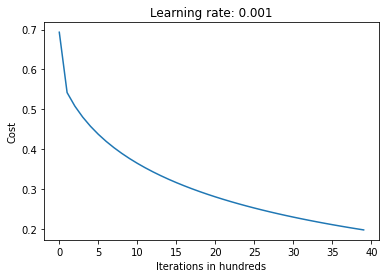

In [18]:
costs = np.squeeze(d["costs"])

plt.ylabel("Cost")
plt.xlabel("Iterations in hundreds")
plt.title("Learning rate: " + str(d["learning_rate"]))

plt.plot(costs)
plt.show()

Try different learning rates and plot the cost functions for comparison.

In [19]:
learning_rates = [0.001, 0.002, 0.0025, 0.003]
models = {}
for rate in learning_rates:
  print("Learning rate: ", rate)
  models[str(rate)] = model(x_train, y_train, x_test, y_test, 4000, rate, False)
  print("\n")

print("Done.")

Learning rate:  0.001
Train accuracy:  96.88311688311688
Test accuracy:  66.66666666666667


Learning rate:  0.002
Train accuracy:  98.96103896103897
Test accuracy:  65.45454545454545


Learning rate:  0.0025
Train accuracy:  99.48051948051948
Test accuracy:  66.06060606060606


Learning rate:  0.003
Train accuracy:  99.74025974025975
Test accuracy:  66.06060606060606


Done.


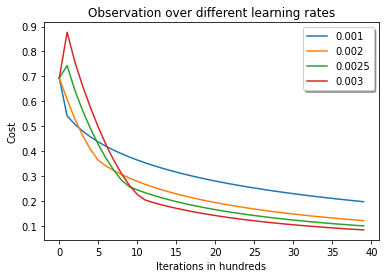

In [20]:
for rate in learning_rates:
  plt.plot(np.squeeze(models[str(rate)]["costs"]), label=str(rate))

plt.ylabel("Cost")
plt.xlabel("Iterations in hundreds")
plt.title("Observation over different learning rates")

plt.legend(loc='upper right', shadow=True)

plt.show()

Test on some random images outside the dataset.

The image is a bird.


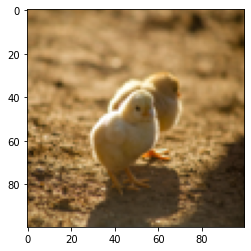

In [21]:
bird_image_path = r'/content/drive/MyDrive/colab/datasets/images/chicken.jpg'
bird_image = Image.open(bird_image_path).convert('RGB')
bird_image = bird_image.resize((100,100))

bird_image_array = np.array(bird_image)
bird_image_array = bird_image_array.reshape((n_px * n_px * 3, 1))
bird_image_array = bird_image_array / 255.

plt.imshow(bird_image)

prediction = np.squeeze(predict(d["w"], d["b"], bird_image_array))
if prediction == 0:
  print("The image is a bird.")
else:
  print("The image is not a bird.") 


The image is not a bird.


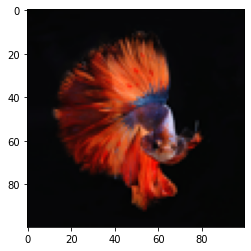

In [22]:
not_bird_image_path = r'/content/drive/MyDrive/colab/datasets/images/not_bird.jpg'
not_bird_image = Image.open(not_bird_image_path).convert("RGB")
not_bird_image = not_bird_image.resize((100, 100))

not_bird_image_array = np.array(not_bird_image)
not_bird_image_array = not_bird_image_array.reshape((n_px * n_px * 3, 1))
not_bird_image_array = not_bird_image_array / 255.

plt.imshow(not_bird_image)

prediction = np.squeeze(predict(d["w"], d["b"], not_bird_image_array))
if prediction == 0:
  print("The image is a bird.")
else:
  print("The image is not a bird.") 

Increase the number of iterations to draw some final conclusions.

In [23]:
d = model(x_train, y_train, x_test, y_test, num_iterations=6000, learning_rate=0.002, print_cost=False)

Train accuracy:  99.74025974025975
Test accuracy:  66.06060606060606


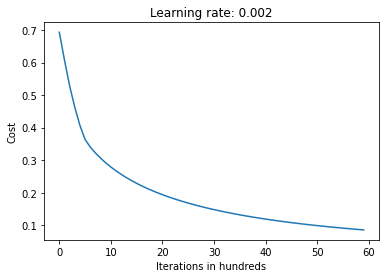

In [24]:
costs1 = np.squeeze(d["costs"])

plt.ylabel("Cost")
plt.xlabel("Iterations in hundreds")
plt.title("Learning rate: " + str(d["learning_rate"]))

plt.plot(costs1)
plt.show()

### **Conclusions:**
The high accuracy in training (which can go around 99%) reflects the fact that the model is capable in some sense to fit the data, but the relative low accuracy in testing is explained by the limitations that come with a simple algorithm as Logistic Regression. One can increase further the number of iterations or searching for better learning rates, but then eventually would end up overfitting the model. Other optimizations such as manipulating the training batches or having a dynamic learning rate can also be applied, but are not quite the purpose of this notebook.